## Build the Model for the December approach

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin

num_transformer = Pipeline([
    ("scaler", StandardScaler())
])

cat_transfomer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, ["Altersgruppe", "FreeBedPercentage", "Notfallreserve"]),
    ("cat", cat_transfomer, ["Bundesland", "Landkreis", "Geschlecht"])
])

model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression())
])

# Creating the grid-search-parameters
gs_params = [
    {
        'clf' : [LogisticRegression()],
        'clf__C' : np.logspace(0, 4, 10)
    },
    {
        'clf' : [LinearSVC()],
        'clf__class_weight' : ['balanced'],
        'clf__C' : [1.0, 8.0]
    },
    {
        'clf' : [RandomForestClassifier()],
        'clf__n_estimators' : [10, 50, 100]
    }
]

In [3]:
import modules.DataLoader as DataLoader

%load_ext autoreload
%autoreload 2

features = ["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht", "Meldedatum", "BelegteBetten", "FreieBetten", "Notfallreserve", "COVID-19-Faelle" ,"Deathcase"]

# load the dataset for training
covid19, features = DataLoader.load_covid19_for_deathcase(features=features, cleaned=True, decData=True,intensivBedData=True)

covid19.head(5)

,Bundesland,Landkreis,Altersgruppe,Geschlecht,Meldedatum,BelegteBetten,FreieBetten,Notfallreserve,COVID-19-Faelle,Deathcase,FreeBedPercentage,FullBedCovidPercentage
0,Schleswig-Holstein,SK Kiel,3.0,M,2020-11-09,545.0,338.0,433.0,27.0,False,0.382786,0.049541
1,Schleswig-Holstein,SK Kiel,3.0,M,2020-11-09,545.0,338.0,433.0,27.0,False,0.382786,0.049541
2,Schleswig-Holstein,SK Kiel,3.0,M,2020-11-09,545.0,338.0,433.0,27.0,False,0.382786,0.049541
3,Schleswig-Holstein,SK Kiel,3.0,M,2020-11-10,586.0,285.0,431.0,23.0,False,0.327210,0.039249
5,Schleswig-Holstein,SK Kiel,3.0,M,2020-11-10,586.0,285.0,431.0,23.0,False,0.327210,0.039249


  Training-Data :
	X_train :  (350656, 6)
	y_train :  (350656,)

   Testing-Data :
	X_test  :  (87665, 6)
	y_test  :  (87665,)

Training model ...
Shape of data:  (350656, 6)
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   12.5s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   18.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   22.5s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.6s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   38.8s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   47.3s
[Parallel(n_jobs=12)]: Done  60 out of  75 | elapsed:  2.9min remaining:   44.1s
[Parallel(n_jobs=12)]: Done  68 out of  75 | elapsed: 10.2min remaining:  1.0min
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed: 14.9min finished
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
 

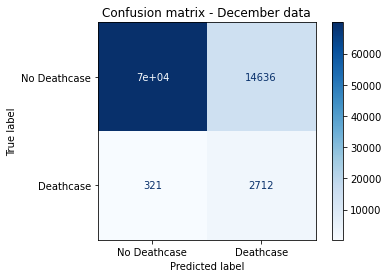

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

import pickle

features = ["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht", "FreeBedPercentage", "Notfallreserve", "Deathcase"]

X_train, X_test, y_train, y_test = train_test_split(
    covid19[features[:-1]], 
    covid19[features[-1]],
    test_size=0.2,
    random_state=42)

print("  Training-Data :")
print("\tX_train : ", X_train.shape)
print("\ty_train : ", y_train.shape)
print("\n   Testing-Data :")
print("\tX_test  : ", X_test.shape)
print("\ty_test  : ", y_test.shape)

print("\nTraining model ...")
print("Shape of data: ", X_train[features[:-1]].shape)

clf = GridSearchCV(model, gs_params, cv=5, n_jobs=12, scoring="balanced_accuracy", verbose=10)

best_model = clf.fit(X_train, y_train)

print(best_model.best_estimator_)

scores = cross_val_score( best_model.best_estimator_, X_train, y_train, cv=5, n_jobs=12, scoring="balanced_accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# model.fit(X_train, y_train)

# And predicting on the test dataset
print("\nPredicting ...")
y_pred = best_model.best_estimator_.predict(X_test)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred, y_true=y_test)))

print(classification_report(y_test, y_pred, target_names=["No Deathcase", "Deathcase"]))
plot_confusion_matrix(best_model.best_estimator_, X_test, y_test, display_labels=["No Deathcase", "Deathcase"], cmap=plt.cm.Blues)
plt.title("Confusion matrix - December data")
plt.show()


In [5]:
# serialize the model into the release directory
with open('./release/model.pkl', "wb") as pickle_file:
    pickle.dump(best_model.best_estimator_, pickle_file)

  Training-Data :
	X_train :  (350656, 6)
	y_train :  (350656,)

   Testing-Data :
	X_test  :  (87665, 6)
	y_test  :  (87665,)

Training model ...
Shape of data:  (176518, 11)
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   16.4s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   20.7s
[Parallel(n_jobs=12)]: Done  60 out of  75 | elapsed:  1.2min remaining:   17.8s
[Parallel(n_jobs=12)]: Done  68 out of  75 | elapsed:  2.7min remaining:   16.7s
[Parallel(n_jobs=12)]: Done  75 out of  75 | elapsed:  4.0min finished
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',


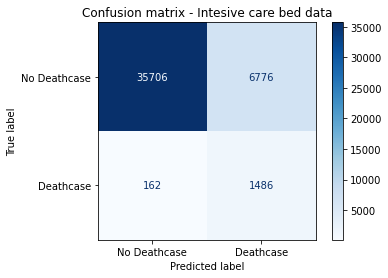

In [6]:
# recreating the earlier model to make the evaluate them with the RP-Curve
features = ["Bundesland", "Landkreis", "Altersgruppe", "Geschlecht", "Meldedatum", "BelegteBetten", "FreieBetten", "Notfallreserve", "COVID-19-Faelle" ,"Deathcase"]

# loading old data
covid19_old, features_old = DataLoader.load_covid19_for_deathcase(features=features, cleaned=True, decData=False,intensivBedData=True)

X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(
    covid19_old[features[:-1]], 
    covid19_old[features[-1]],
    test_size=0.2,
    random_state=42)

print("  Training-Data :")
print("\tX_train : ", X_train.shape)
print("\ty_train : ", y_train.shape)
print("\n   Testing-Data :")
print("\tX_test  : ", X_test.shape)
print("\ty_test  : ", y_test.shape)

print("\nTraining model ...")
print("Shape of data: ", X_train_old[features[:-1]].shape)

clf_old = GridSearchCV(model, gs_params, cv=5, n_jobs=12, scoring="balanced_accuracy", verbose=10)

best_model_old = clf_old.fit(X_train_old, y_train_old)

print(best_model_old.best_estimator_)

scores = cross_val_score( best_model_old.best_estimator_, X_train_old, y_train_old, cv=5, n_jobs=12, scoring="balanced_accuracy")

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# And predicting on the test dataset
print("\nPredicting ...")
y_pred_old = best_model_old.best_estimator_.predict(X_test_old)

print("Accuracy: {0:.2f}".format(accuracy_score(y_pred=y_pred_old, y_true=y_test_old)))

print(classification_report(y_test_old, y_pred_old, target_names=["No Deathcase", "Deathcase"]))
plot_confusion_matrix(best_model_old.best_estimator_, X_test_old, y_test_old, display_labels=["No Deathcase", "Deathcase"], cmap=plt.cm.Blues)
plt.title("Confusion matrix - Intesive care bed data")
plt.show()

Text(0.5, 1.0, 'RP-Curves')

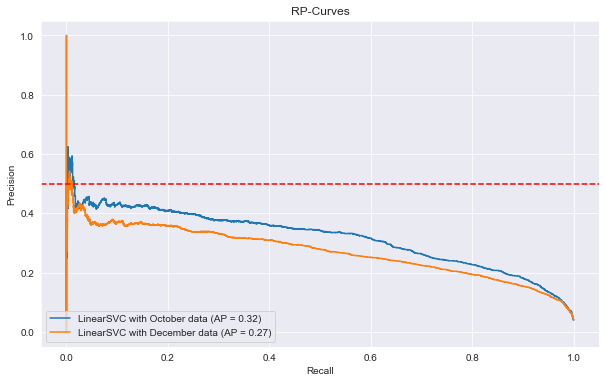

In [8]:
from sklearn.metrics import plot_precision_recall_curve
import seaborn as sns
sns.set_style("darkgrid")

plot_precision_recall_curve(best_model_old.best_estimator_, X_test_old, y_test_old, ax= plt.gca(), name="LinearSVC with October data")
plot_precision_recall_curve(best_model.best_estimator_, X_test, y_test, ax=plt.gca(), name="LinearSVC with December data")

plt.axhline(y=0.5, color="red", linestyle='--', label='No Skill')

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("RP-Curves")